In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions


,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
107,Z:\Data\FujisawaS\EE\EE0705fm
108,Z:\Data\FujisawaS\EE\EE0706fm
109,Z:\Data\FujisawaS\EE\EE0708fm
110,Z:\Data\HMC1\day12


In [295]:
basepath = r"Z:\Data\HMC1\day13"
reference_region=["CA1"]
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
min_cells=5
ripple_expand=0.1
min_ripples=10
n_shuff=1000
rank=10
reg=1e-6
target_cell_type=None
(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
) = predict_downstream_reduced_rank_regressor.get_data(
    basepath, target_regions, reference_region, ripple_expand
)

In [480]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

ep = ep_epochs[0]
st_par = functions.get_participation(
    st[ep].data,
    ripple_epochs[ep].starts,
    ripple_epochs[ep].stops,
    par_type="firing_rate",
)

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(st_par)

ca1_idx = (
    cm.brainRegion.str.contains("CA1").values
    & (cm.deepSuperficial == "Deep")
    & cm.putativeCellType.str.contains("Pyr")
)

target_idx = cm.brainRegion.str.contains("MEC").values

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_idx, :].T,
    X[target_idx, :].T,
    test_size=0.4,
    random_state=42,
)

In [512]:
score = []
sqerr = []
for i in range(1,100):
    regressor = reduced_rank_regressor.ReducedRankRegressor(
        X_train, y_train, i, reg
    )
    score.append(regressor.score(X_test, y_test))
    sqerr.append(predict_downstream_reduced_rank_regressor.sqerr(y_test, regressor.predict(X_test)))

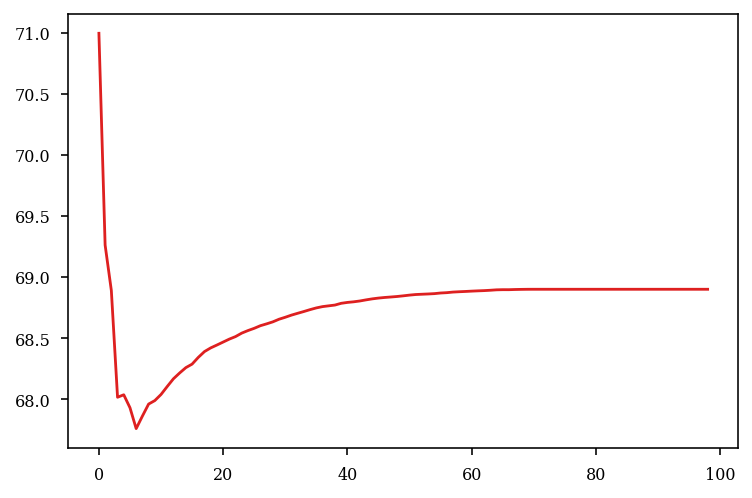

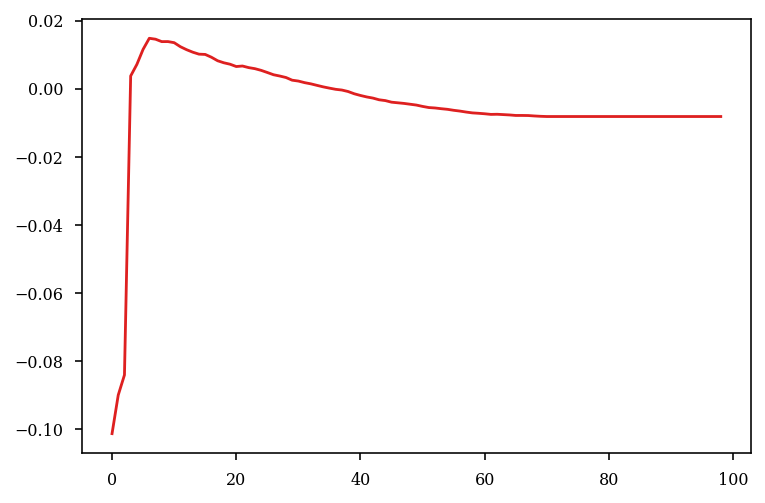

In [513]:
plt.plot(sqerr)
plt.show()
plt.plot(score)

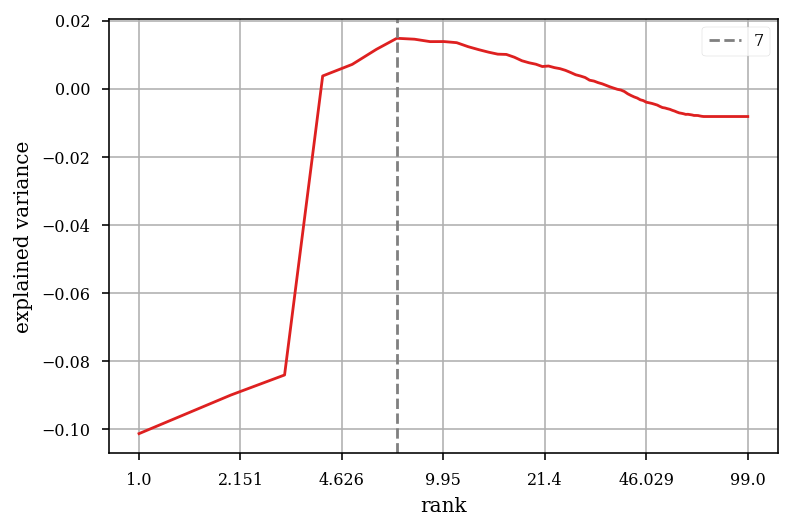

In [514]:
x = range(1, 100)
plt.plot(np.log10(x), score)

ax = plt.gca()
custom_plots.restore_natural_scale(
    ax, np.min(np.log10(x)), np.max(np.log10(x)), n_steps=7, x_axis=True, y_axis=False
)

plt.axvline(np.log10(np.argmax(score)+1), color="grey", linestyle="--", label=np.argmax(score)+1)
plt.xlabel("rank")
plt.ylabel("explained variance")
plt.legend()
# plt.ylim(0,1.1)
plt.grid()

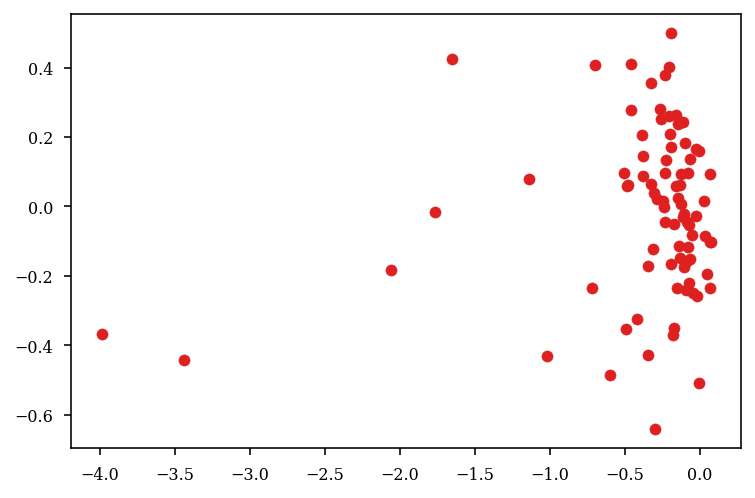

In [504]:
regressor = reduced_rank_regressor.ReducedRankRegressor(
    X_train, y_train, np.argmax(score)+1, reg
)
plt.scatter(np.array(regressor.A[0,:]),np.array(regressor.A[1,:]))
# plt.plot(np.array(regressor.A[0,:]).T,np.array(regressor.A[1,:]).T)
plt.show()

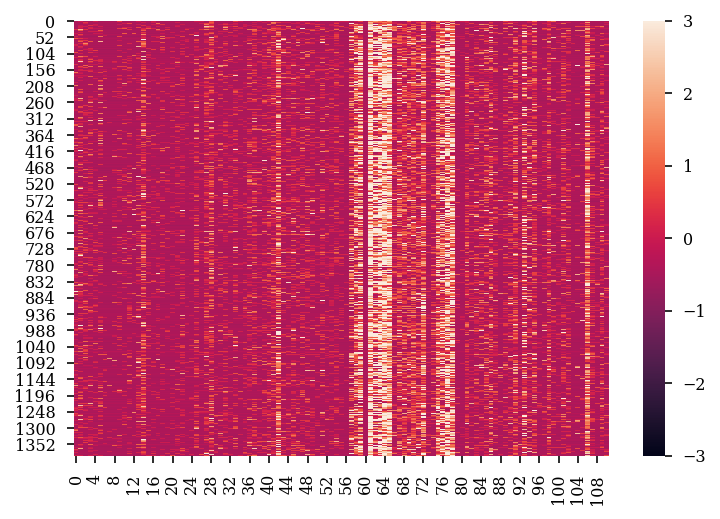

<AxesSubplot:>

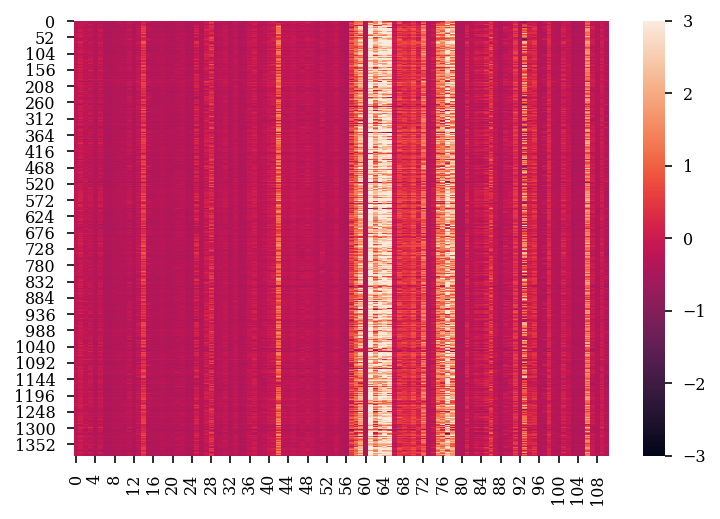

In [488]:
sns.heatmap(y_test,vmax=3,vmin=-3)
plt.show()
sns.heatmap(regressor.predict(X_test),vmax=3,vmin=-3)


In [478]:
np.array(regressor.predict(X[ca1_idx, :].T)[:,64]).T

array([[1.36297157, 1.46405196, 1.4972046 , ..., 1.38959108, 1.12311598,
        1.39808186]])

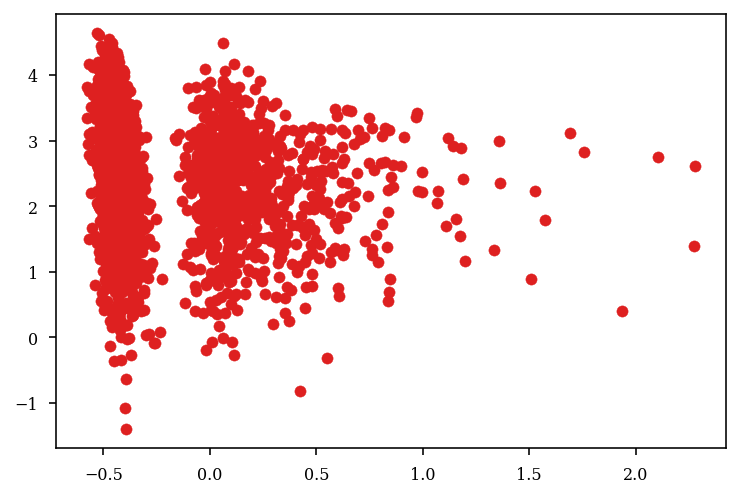

In [489]:
plt.scatter(X[ca1_idx, :][64,:], np.array(regressor.predict(X[ca1_idx, :].T)[:,64]))
plt.show()

(0.0, 50.0)

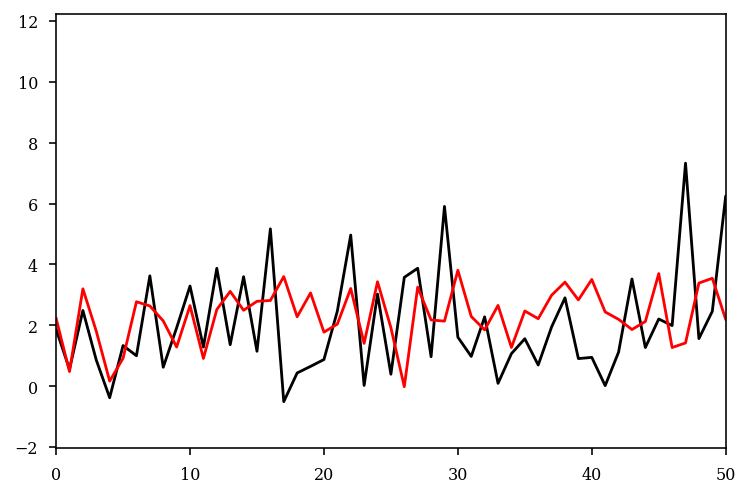

In [490]:

plt.plot(y_test[:,64],color="k")
plt.plot(regressor.predict(X_test)[:,64],color="red")
plt.xlim(0,50)

In [558]:
from sklearn.cross_decomposition import CCA,PLSCanonical,PLSRegression
# from sklearn.cross_decomposition import PLSCanonical
cca = CCA().fit(X_train, y_train)
print(cca.score(X_test, y_test))

plsca  = PLSCanonical().fit(X_train, y_train)
print(plsca.score(X_test, y_test))

pls2 = PLSRegression().fit(X_train, y_train)
print(pls2.score(X_test, y_test))

regressor = reduced_rank_regressor.ReducedRankRegressor(
    X_train, y_train, 7, reg
)
print(regressor.score(X_test, y_test))

0.017945999447261583
0.02321443372573891
0.031080758254697517
0.014783476139704176


In [567]:
X_train.T.shape, y_train.T.shape

((71, 1735), (111, 1735))

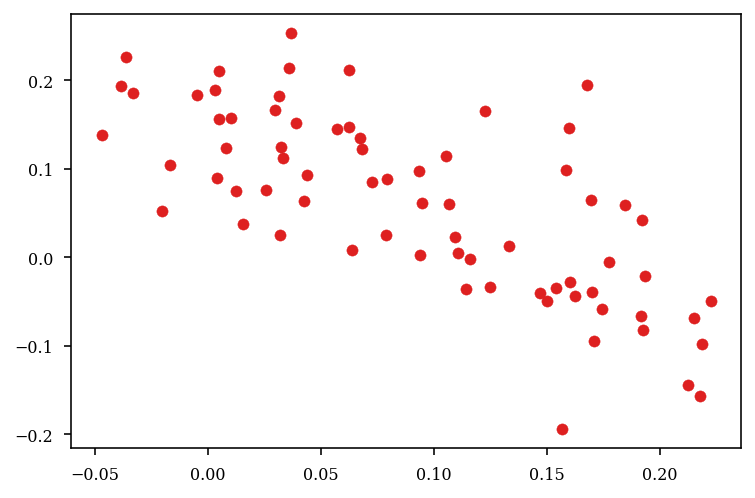

In [573]:
pls2 = PLSRegression().fit(X_train, y_train)

plt.scatter(pls2.x_rotations_[:,0],pls2.x_rotations_[:,1])

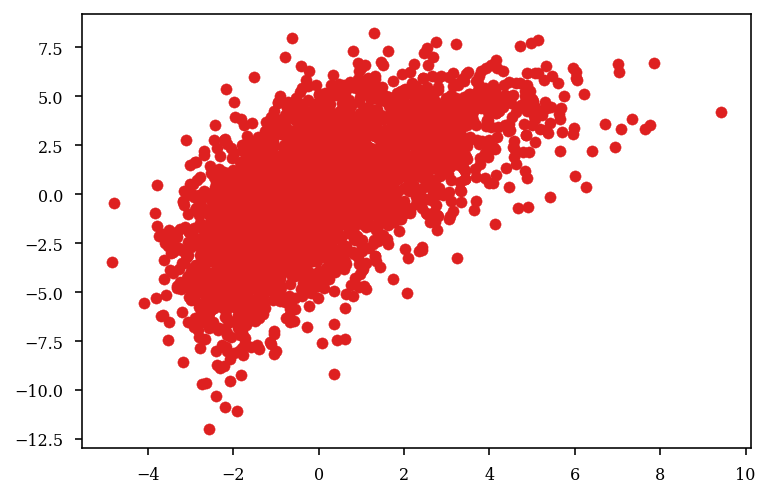

In [543]:
X_c, Y_c = pls2.transform(X_test, y_test)
plt.scatter(X_c, Y_c)

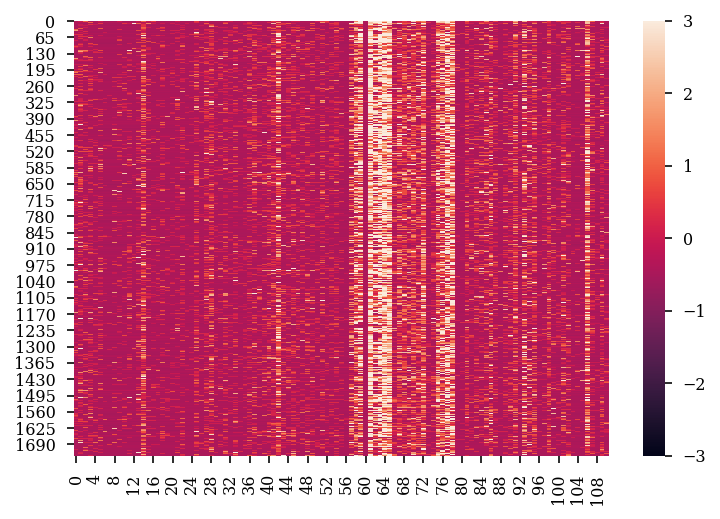

<AxesSubplot:>

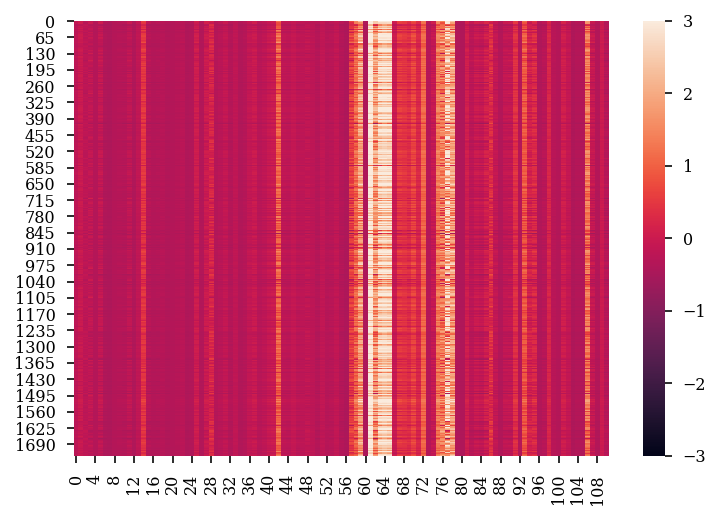

In [542]:
sns.heatmap(y_test,vmax=3,vmin=-3)
plt.show()
sns.heatmap(pls2.predict(X_test),vmax=3,vmin=-3)

(-1.0, 3.0)

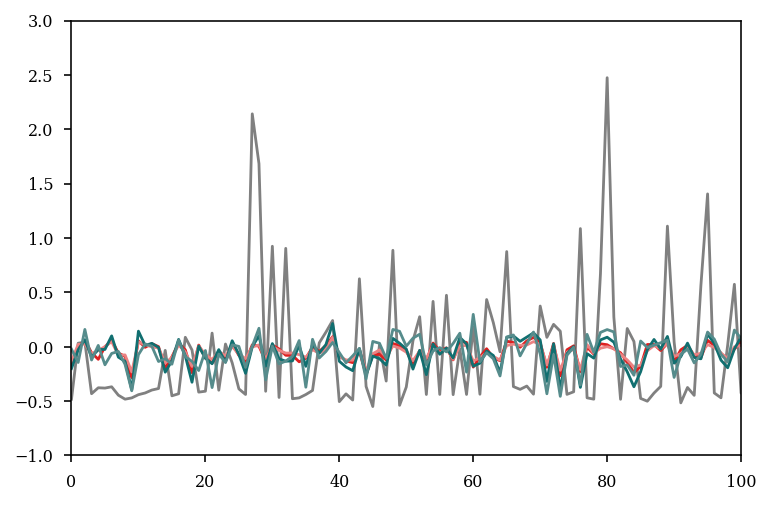

In [559]:
plt.plot(y_test[:,1],color="grey")

plt.plot(pls2.predict(X_test)[:,1])
plt.plot(plsca.predict(X_test)[:,1])
plt.plot(cca.predict(X_test)[:,1])
plt.plot(regressor.predict(X_test)[:,1])


plt.xlim(0,100)
plt.ylim(-1,3)
# plt.axis("tight")

In [613]:
np.arange(0,1,.02)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])

## test ripple expansion param

In [614]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

score = []
for ripple_expand in np.arange(0,1,.02):
    (
        st,
        cm,
        ripple_epochs,
        ep_epochs,
        ep_df,
    ) = predict_downstream_reduced_rank_regressor.get_data(
        basepath, target_regions, reference_region, ripple_expand
    )

    ep = ep_epochs[0]
    st_par = functions.get_participation(
        st[ep].data,
        ripple_epochs[ep].starts,
        ripple_epochs[ep].stops,
        par_type="firing_rate",
    )

    scaler = preprocessing.StandardScaler()

    X = scaler.fit_transform(st_par)

    ca1_idx = (
        cm.brainRegion.str.contains("CA1").values
        & (cm.deepSuperficial == "Deep")
        & cm.putativeCellType.str.contains("Pyr")
    )

    target_idx = cm.brainRegion.str.contains("MEC").values

    X_train, X_test, y_train, y_test = train_test_split(
        X[ca1_idx, :].T,
        X[target_idx, :].T,
        test_size=0.4,
        random_state=42,
    )

    pls2 = PLSRegression().fit(X_train, y_train)
    score.append(pls2.score(X_test, y_test))

In [ ]:
from sklearn.model_selection import GridSearchCV

N_PARAMETERS_GRID_SEARCH = 20

rrr = reduced_rank_regressor.ReducedRankRegressor

rank_grid = np.linspace(
    1, min(min(X_train.shape), min(y_train.shape)), num=N_PARAMETERS_GRID_SEARCH
).astype(int)

reg_grid = np.power(10,np.linspace(-20,20, num=N_PARAMETERS_GRID_SEARCH+1))

parameters_grid_search  = {'reg':reg_grid, 'rank':rank_grid}

grid_search = GridSearchCV(
    rrr,
    parameters_grid_search,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)


In [ ]:
# results = predict_downstream_reduced_rank_regressor.run(basepath,n_shuff=500)


In [576]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\predict_downstream_rr_v7"

batch_analysis.run(
    df_sessions,
    save_path,
    predict_downstream_reduced_rank_regressor.run,
    parallel=True,
    verbose=True,
)
# load results
results = predict_downstream_reduced_rank_regressor.load_results(save_path)


100%|██████████| 112/112 [00:47<00:00,  2.38it/s]


In [577]:
results["prediction_gain_median"] = results.median_error_shuff / results.training_error
results["prediction_gain_mean"] = results.mean_error_shuff / results.training_error
results.loc[results.targ_reg == "EC1|EC2|EC3|EC4|EC5|MEC", "targ_reg"] = "MEC"
results.loc[results.epoch_i == 0, "epoch_i"] = "pre"
results.loc[results.epoch_i == 1, "epoch_i"] = "task"
results.loc[results.epoch_i == 2, "epoch_i"] = "post"
results["ca1_sub_layer_targ_reg"] = results["ca1_sub_layer"] + "_" + results["targ_reg"]


In [578]:
results


,epoch,epoch_i,targ_reg,ca1_sub_layer,n_x_components,training_error,testing_error,r2_rrr_train,r2_rrr_test,r2_cca,...,median_error_shuff,mean_r2_shuff,median_r2_shuff,pvalues,n_ca1,n_target_cells,basepath,prediction_gain_median,prediction_gain_mean,ca1_sub_layer_targ_reg
0,sleep,pre,MEC,Deep,1912,0.84927,0.96129,-1.227233,-1.420184,-0.033269,...,1.072945,-1.791477,-1.783886,1.000000,12,10,Z:\Data\AYAold\AYA7\day19,1.263373,1.267121,Deep_MEC
1,linear,task,MEC,Deep,397,1.09662,1.36643,-3.481467,-6.055908,-0.305438,...,1.430630,-6.538420,-6.364528,1.000000,12,10,Z:\Data\AYAold\AYA7\day19,1.304581,1.332407,Deep_MEC
2,sleep,post,MEC,Deep,1735,0.30996,0.27666,0.316758,0.486914,0.466638,...,0.388595,-0.545659,-0.537410,1.000000,12,10,Z:\Data\AYAold\AYA7\day19,1.253694,1.256868,Deep_MEC
3,sleep,pre,MEC,Deep,3329,3.75574,4.07003,-0.769928,-1.357136,0.047911,...,4.180235,-1.468896,-1.386290,1.000000,17,44,Z:\Data\AYAold\AYA7\day20,1.113026,1.118280,Deep_MEC
4,linear,task,MEC,Deep,840,2.45629,2.59298,-0.076256,0.002747,0.142428,...,2.819955,-1.049223,-0.701915,1.000000,17,44,Z:\Data\AYAold\AYA7\day20,1.148055,1.181218,Deep_MEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,sleep,post,MEC,Superficial,789,6.13297,8.19641,-0.644493,-1.222412,-0.014293,...,9.248495,-1.012182,-1.005400,1.000000,13,14,Z:\Data\Kenji\i01_maze01_MS.001_003,1.507996,1.512249,Superficial_MEC
238,sleep,pre,PFC,Deep,2703,2.31834,2.61545,0.067337,0.041908,0.051598,...,2.786225,-0.128425,-0.128097,1.000000,19,15,Z:\Data\ORproject\OR18\day1,1.201819,1.201646,Deep_PFC
239,sleep,post,PFC,Deep,1680,2.94268,2.96654,0.086380,0.038964,0.038219,...,3.143485,-0.150564,-0.150430,1.000000,19,15,Z:\Data\ORproject\OR18\day1,1.068239,1.068210,Deep_PFC
240,sleep,pre,PFC,Deep,282,5.40105,6.16813,0.106262,-0.049882,-0.007945,...,6.412865,-0.119446,-0.119365,0.724276,14,17,Z:\Data\ORproject\OR18\day2,1.187337,1.188874,Deep_PFC


In [581]:
results.keys()

Index(['epoch', 'epoch_i', 'targ_reg', 'ca1_sub_layer', 'n_x_components',
       'training_error', 'testing_error', 'r2_rrr_train', 'r2_rrr_test',
       'r2_cca', 'r2_plsc', 'r2_plsr', 'mean_error_shuff',
       'median_error_shuff', 'mean_r2_shuff', 'median_r2_shuff', 'pvalues',
       'n_ca1', 'n_target_cells', 'basepath', 'prediction_gain_median',
       'prediction_gain_mean', 'ca1_sub_layer_targ_reg'],
      dtype='object')

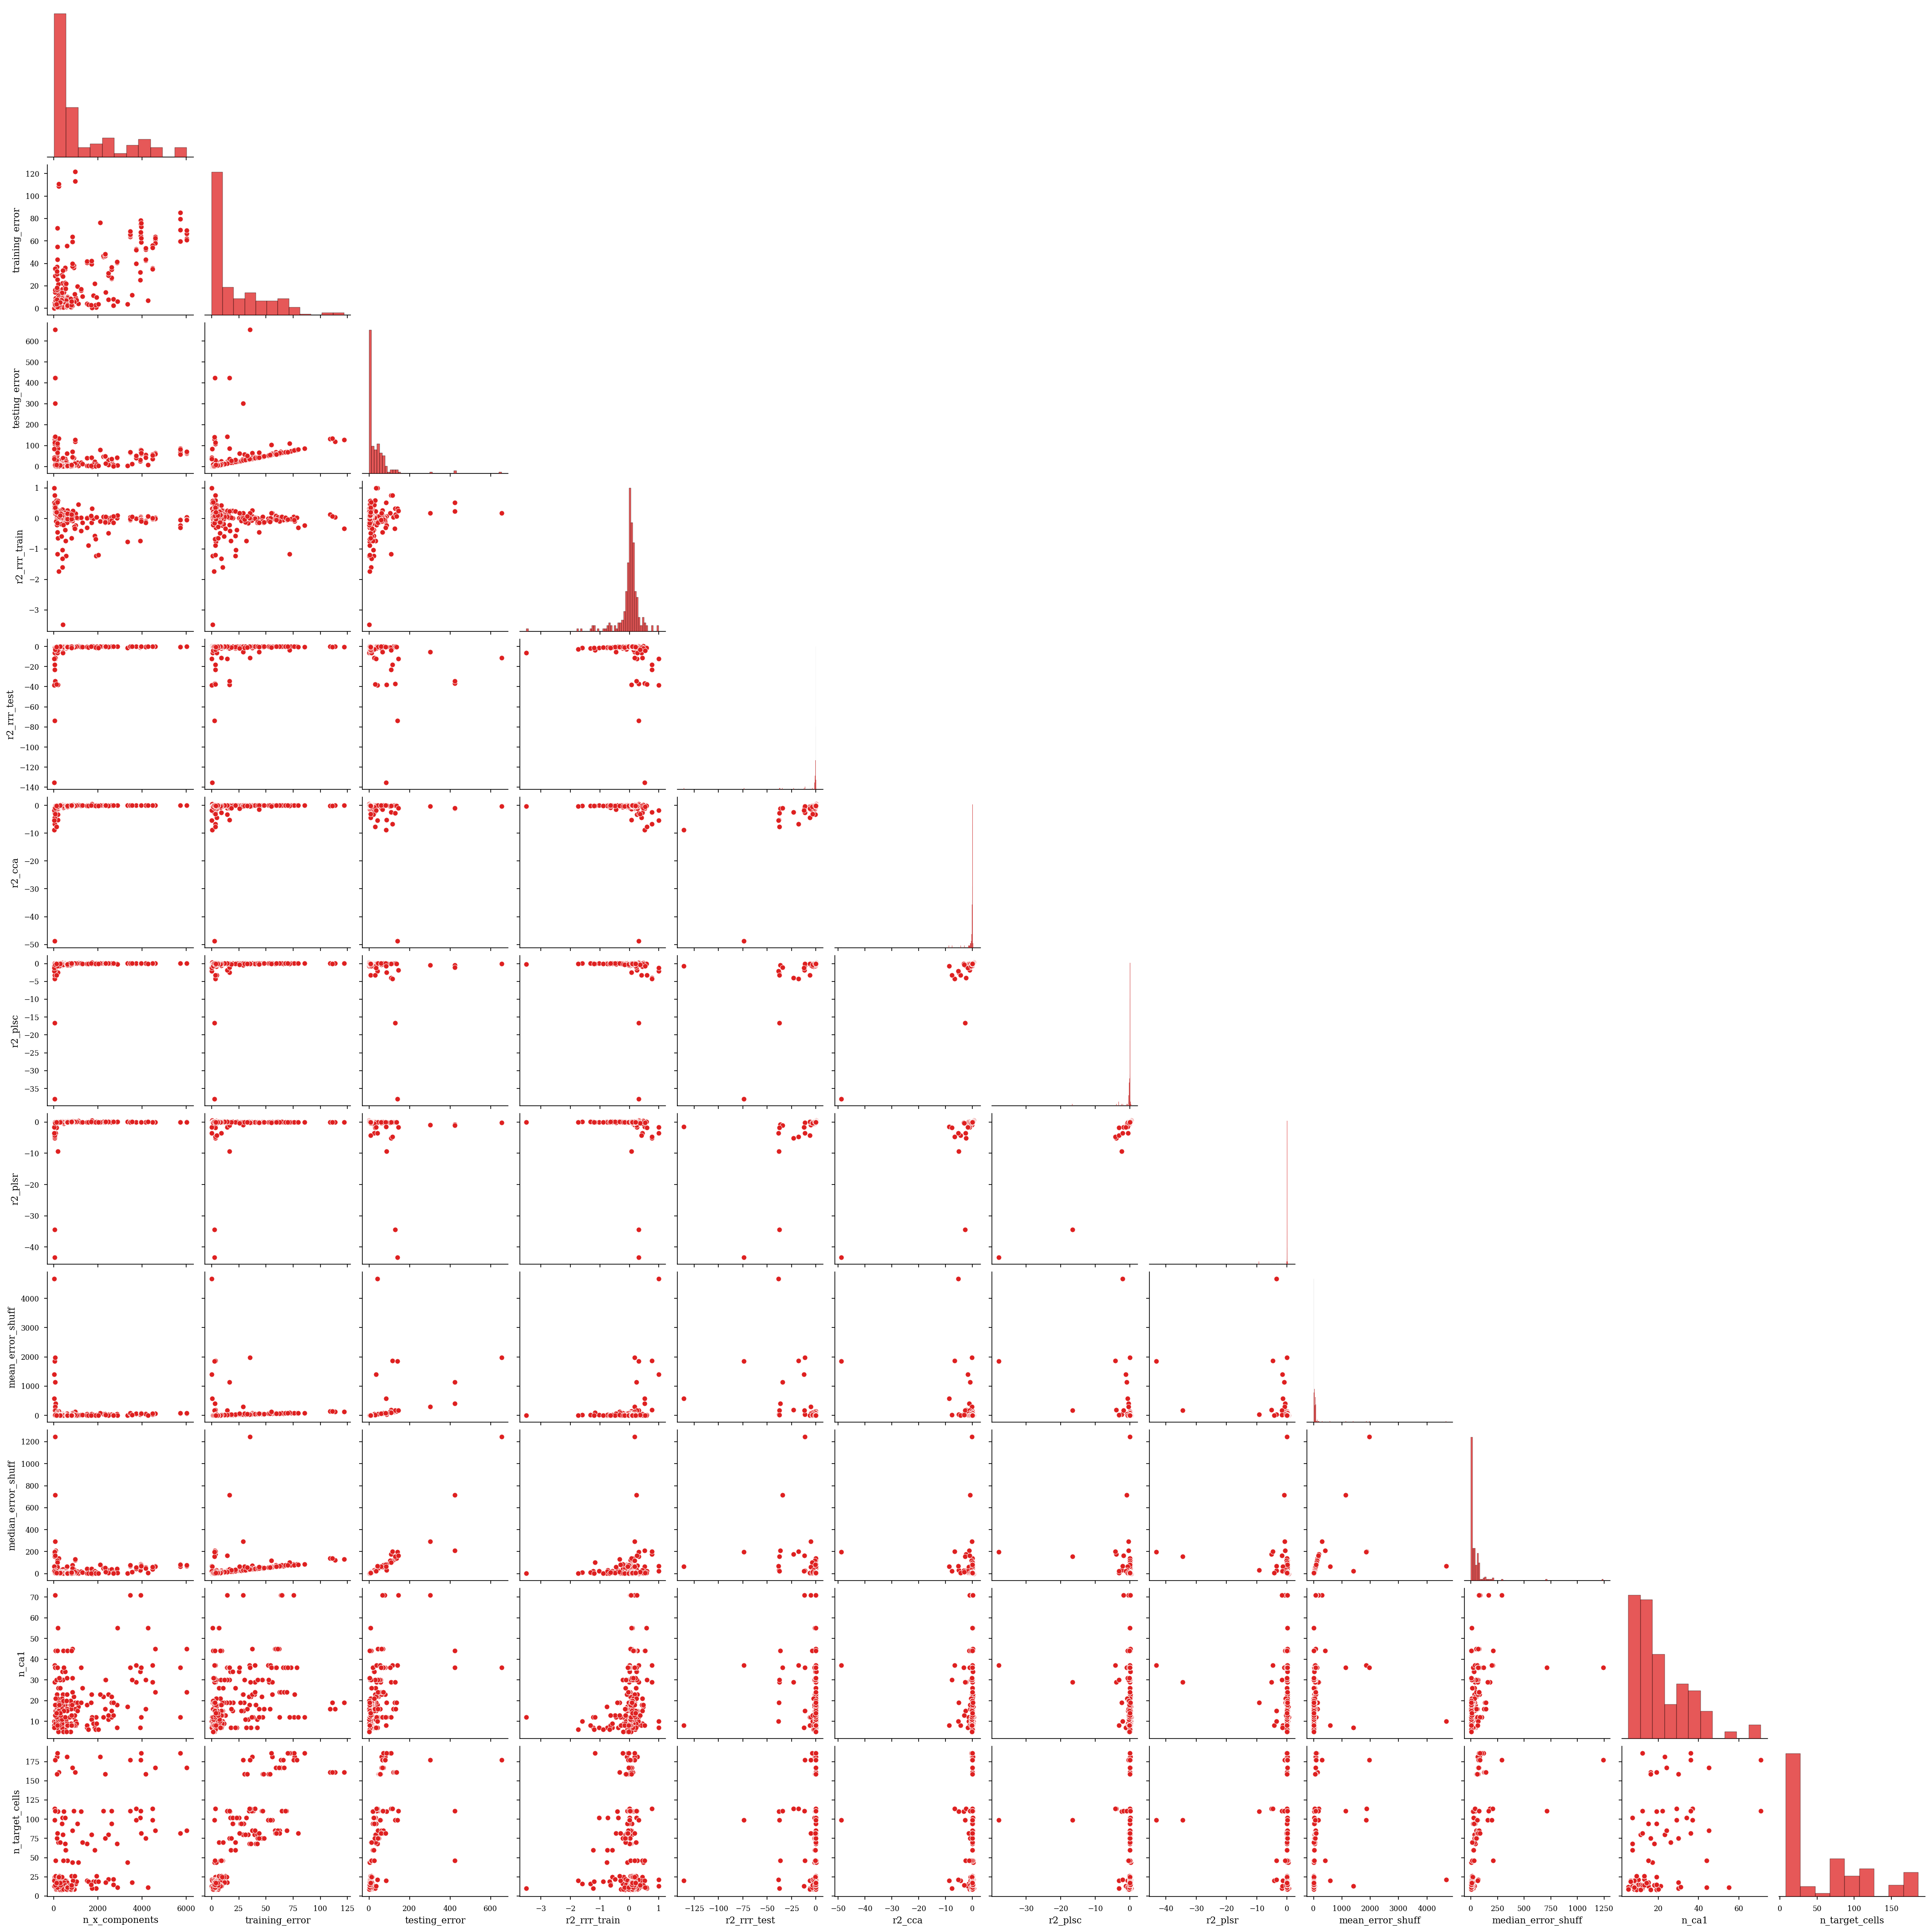

In [582]:
sns.pairplot(
    results[
        [
            "n_x_components",
            "training_error",
            "testing_error",
            "r2_rrr_train",
            "r2_rrr_test",
            "r2_cca",
            "r2_plsc",
            "r2_plsr",
            "mean_error_shuff",
            "median_error_shuff",
            "n_ca1",
            "n_target_cells",
        ]
    ],
    corner=True,
)


## testing error

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

post_Deep_PFC v.s. post_Superficial_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.101e-01 U_stat=2.000e+01
task_Deep_PFC v.s. task_Superficial_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.300e+01
post_Deep_MEC v.s. post_Superficial_MEC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.570e+02
pre_Deep_PFC v.s. pre_Superficial_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.200e+01
pre_Deep_MEC v.s. pre_Superficial_MEC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.550e+02
task_Deep_MEC v.s. task_Superficial_MEC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.320e+02


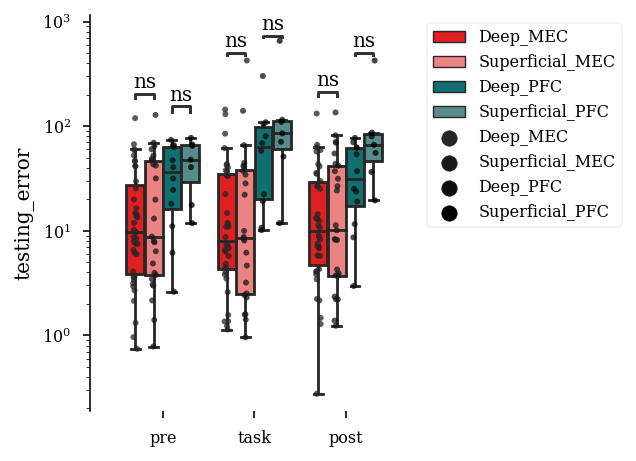

In [583]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)

group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="testing_error",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
    saturation=1,
)
p2 = sns.stripplot(
    y="testing_error",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    data=results,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)

# # move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("testing_error")
# plt.axhline(1, color="grey", linestyle="--")
plt.yscale("log")
plt.xlabel("")

box_pairs = [
    (("pre", "Deep_MEC"), ("pre", "Superficial_MEC")),
    (("pre", "Deep_PFC"), ("pre", "Superficial_PFC")),
    (("task", "Deep_MEC"), ("task", "Superficial_MEC")),
    (("task", "Deep_PFC"), ("task", "Superficial_PFC")),
    (("post", "Deep_MEC"), ("post", "Superficial_MEC")),
    (("post", "Deep_PFC"), ("post", "Superficial_PFC")),
]
add_stat_annotation(plt.gca(),data=results,y="testing_error",x="epoch_i",hue="ca1_sub_layer_targ_reg",
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="inside",
    verbose=2,
)
plt.show()

# plt.grid()
# results["basepath_ca1_sub_layer_targ_reg"] = results.basepath + "_" + results.ca1_sub_layer_targ_reg
# sns.lineplot(data=results, x="epoch_i", y="testing_error",hue="basepath_ca1_sub_layer_targ_reg",legend=False)
# plt.yscale("log")
# ValueError: test value should be one of the following: t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.


In [585]:
results.keys()

Index(['epoch', 'epoch_i', 'targ_reg', 'ca1_sub_layer', 'n_x_components',
       'training_error', 'testing_error', 'r2_rrr_train', 'r2_rrr_test',
       'r2_cca', 'r2_plsc', 'r2_plsr', 'mean_error_shuff',
       'median_error_shuff', 'mean_r2_shuff', 'median_r2_shuff', 'pvalues',
       'n_ca1', 'n_target_cells', 'basepath', 'prediction_gain_median',
       'prediction_gain_mean', 'ca1_sub_layer_targ_reg'],
      dtype='object')

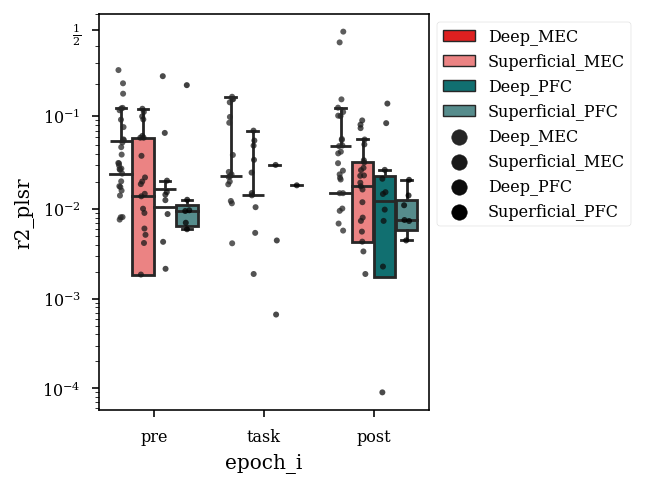

In [611]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)

group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="r2_plsr",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
    saturation=1,
)
p2 = sns.stripplot(
    y="r2_plsr",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    data=results,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)
plt.yscale("logit")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.ylim(0,.6)

## Main effects

In [147]:
from scipy.stats import mannwhitneyu

x1 = results[(results.ca1_sub_layer_targ_reg == "Superficial_PFC")].testing_error
x2 = results[(results.ca1_sub_layer_targ_reg == "Deep_PFC")].testing_error
U1, p = mannwhitneyu(x1, x2, method="auto",nan_policy="omit")
print('deep vs sup PFC ',U1, p)

x1 = results[(results.ca1_sub_layer_targ_reg == "Superficial_MEC")].testing_error
x2 = results[(results.ca1_sub_layer_targ_reg == "Deep_MEC")].testing_error
U1, p = mannwhitneyu(x1, x2, method="auto",nan_policy="omit")
print('deep vs sup MEC ',U1, p)

x1 = results[(results.ca1_sub_layer_targ_reg.str.contains("MEC"))].testing_error
x2 = results[(results.ca1_sub_layer_targ_reg.str.contains("PFC"))].testing_error
U1, p = mannwhitneyu(x1, x2, method="auto",nan_policy="omit")
print('MEC vs PFC',U1, p)

deep vs sup PFC  486.0 0.026005437610339025
deep vs sup MEC  4312.0 0.7184348617588634
MEC vs PFC 2302.0 4.875646282794603e-10


In [180]:
X = np.random.rand(10,10)
Y = np.random.rand(10,10)
B = np.random.rand(10)

from sklearn.metrics import r2_score

corr_value = r2_score(np.concatenate(X),np.concatenate(Y))
# r2 = np.sum(1-np.abs(Y-X*B)**2 / np.abs(Y)**2)
# r2
corr_value

-1.0053364875544881

In [263]:
from ripple_heterogeneity.utils import reduced_rank_regressor

# simulate data with rank 16 dims
X, Y = reduced_rank_regressor.ideal_data(1000,500,100,16,noise=.5)
# used reduced rank regressor to fit data over multiple ranks
score = []
for i in range(1,100):
    rrr = reduced_rank_regressor.ReducedRankRegressor(X,Y,i)
    score.append(rrr.score(X,Y))

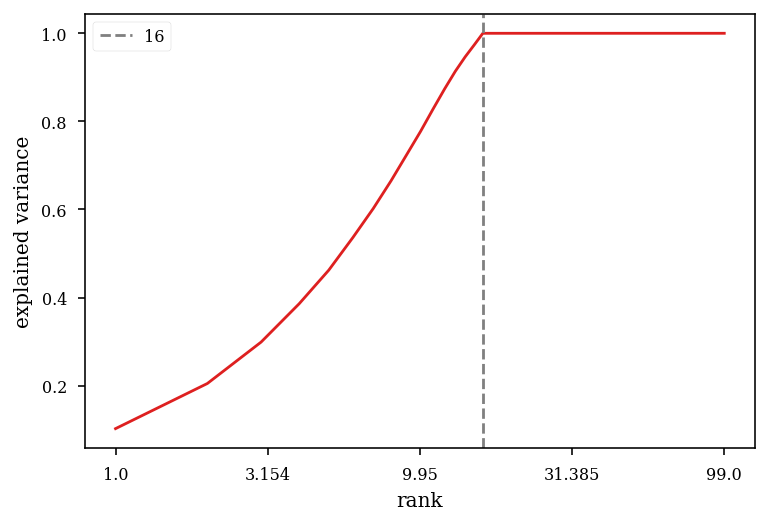

In [294]:
from ripple_heterogeneity.utils import custom_plots

x = range(1, 100)
plt.plot(np.log10(x), score)

ax = plt.gca()
custom_plots.restore_natural_scale(
    ax, np.min(np.log10(x)), np.max(np.log10(x)), n_steps=5, x_axis=True, y_axis=False
)

plt.axvline(np.log10(16), color="grey", linestyle="--", label=16)
plt.xlabel("rank")
plt.ylabel("explained variance")
plt.legend()


In [256]:
from sklearn.metrics import r2_score


r2_score(Y, rrr.predict(X))

0.9860411155913669

In [ ]:
# (rrr.predict(X) - Y)**2

# function to calculate R2
def r2(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

r2(Y, rrr.predict(X))


In [ ]:
1 - np.sqrt(np.mean((rrr.predict(X) - Y) ** 2)) / np.var(Y)


In [243]:
X.shape, Y.shape

((1000, 500), (1000, 100))

In [236]:
rrr.A.shape, rrr.W.shape

((2, 500), (100, 2))

<AxesSubplot:>

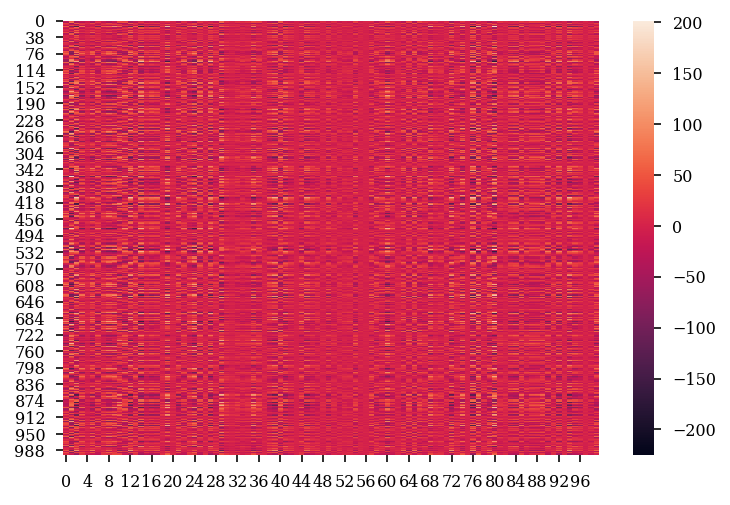

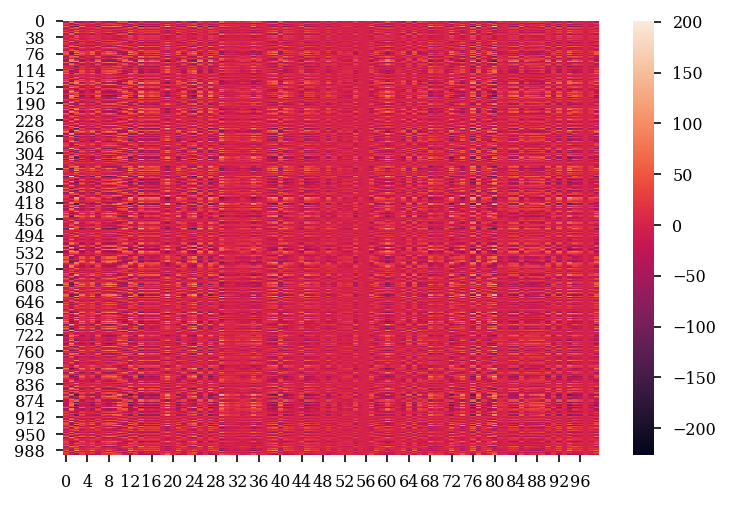

In [241]:
plt.figure()
sns.heatmap(Y)
plt.figure()
sns.heatmap(rrr.predict(X))

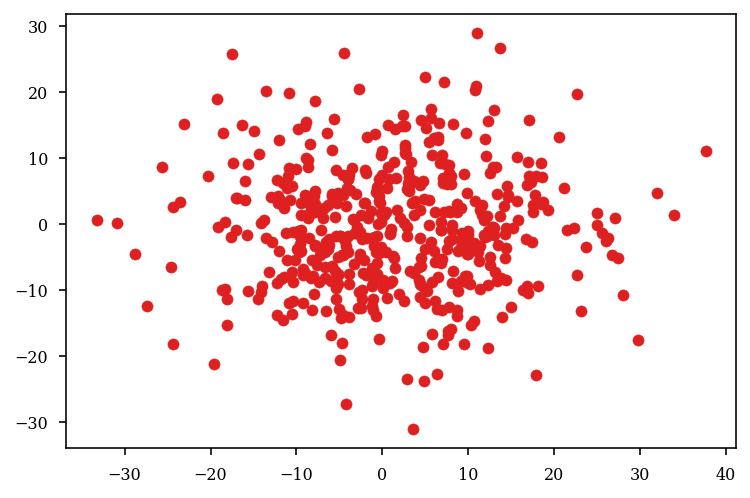

In [244]:
plt.scatter(np.array(rrr.A[0,:]),np.array(rrr.A[1,:]))

In [187]:
rrr.predict(X)

(10, 10)

In [188]:
np.sqrt(np.mean((rrr.predict(X) - Y) ** 2)) / np.var(Y)

0.09013222558613683

In [138]:
# import pingouin as pg
# results["ca1_sub_layer_targ_reg_epoch_i"] = results.ca1_sub_layer_targ_reg + "_" + results.epoch_i
# ax = pg.plot_paired(data=results, dv='testing_error', within='ca1_sub_layer_targ_reg_epoch_i',
#                     subject='basepath',dpi=90,orient='h')
# ax.set_yscale("log")

## Pre task post difference scores

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Superficial_MEC v.s. Superficial_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.892e-02 U_stat=3.300e+01
Deep_MEC v.s. Deep_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.029e-01 U_stat=1.180e+02


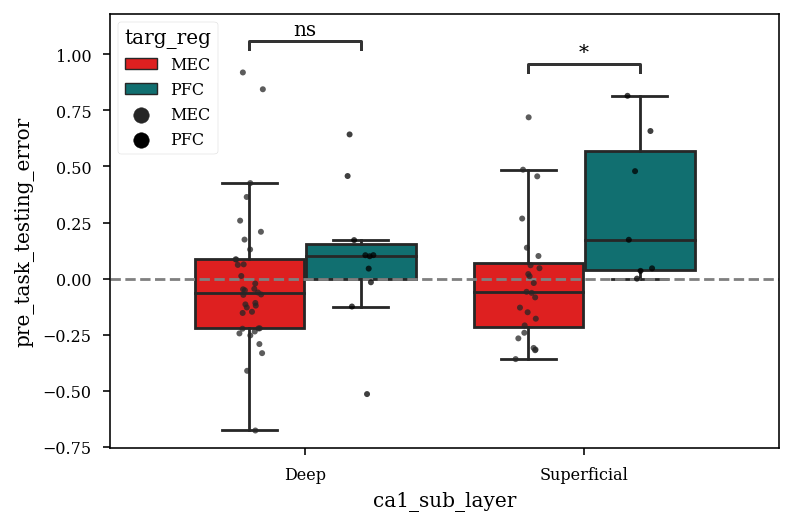

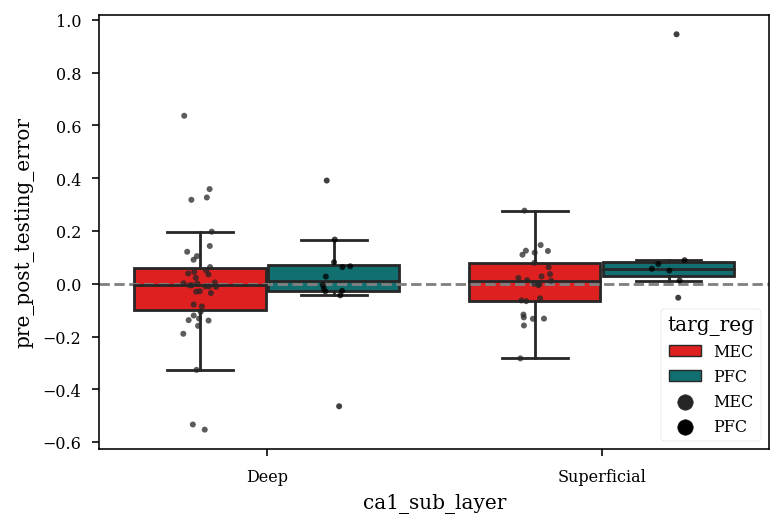

In [102]:
def ab_ratio(a, b):
    return (a - b) / (a + b)

df_wide = pd.pivot(
    results,
    index=["basepath","ca1_sub_layer","targ_reg"],
    columns="epoch_i",
    values=["testing_error"],
).reset_index()


df_wide["pre_task_testing_error"] = ab_ratio(df_wide["testing_error"]["task"] , df_wide["testing_error"]["pre"])
df_wide["pre_post_testing_error"] = ab_ratio(df_wide["testing_error"]["post"] , df_wide["testing_error"]["pre"])
df_wide["constant"] = 1

group_colors = {
    "MEC": "#de2020",
    "PFC": "#116f70",
}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="pre_task_testing_error",
    x="ca1_sub_layer",
    hue="targ_reg",
    data=df_wide,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="pre_task_testing_error",
    x="ca1_sub_layer",
    hue="targ_reg",
    data=df_wide,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)
plt.axhline(0, color="grey", linestyle="--")

box_pairs = [
    (("Deep", "MEC"), ("Deep", "PFC")),
    (("Superficial", "MEC"), ("Superficial", "PFC")),
]
add_stat_annotation(plt.gca(),data=df_wide,y="pre_task_testing_error",
    x="ca1_sub_layer",
    hue="targ_reg",
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="inside",
    verbose=2,
)
plt.figure()
ax = sns.boxplot(
    y="pre_post_testing_error",
    x="ca1_sub_layer",
    hue="targ_reg",
    data=df_wide,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="pre_post_testing_error",
    x="ca1_sub_layer",
    hue="targ_reg",
    data=df_wide,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)
plt.axhline(0, color="grey", linestyle="--")

In [49]:
# from plotnine import ggplot, geom_point, aes, geom_boxplot, geom_line, position_jitterdodge, scales

# (ggplot(results, aes(x='epoch_i', y='testing_error',fill='ca1_sub_layer_targ_reg'))
#  + geom_boxplot() # changed
#  + geom_point()
#  + geom_line(aes(group = "basepath",fill='ca1_sub_layer_targ_reg'))          # new
#  + scales.scale_y_log10()
# ) 

#                         position = pj)

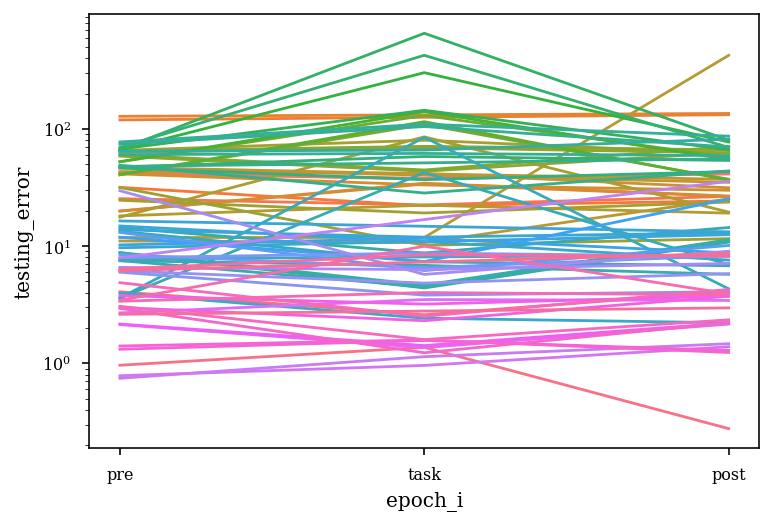

In [115]:
# g = sns.catplot(x="epoch_i", y="testing_error", hue="ca1_sub_layer_targ_reg",
#                 capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
#                 kind="point", data=results)
results["basepath_ca1_sub_layer_targ_reg"] = results.basepath + "_" + results.ca1_sub_layer_targ_reg
sns.lineplot(data=results, x="epoch_i", y="testing_error",hue="basepath_ca1_sub_layer_targ_reg",legend=False)
plt.yscale("log")

Text(0.5, 0, '')

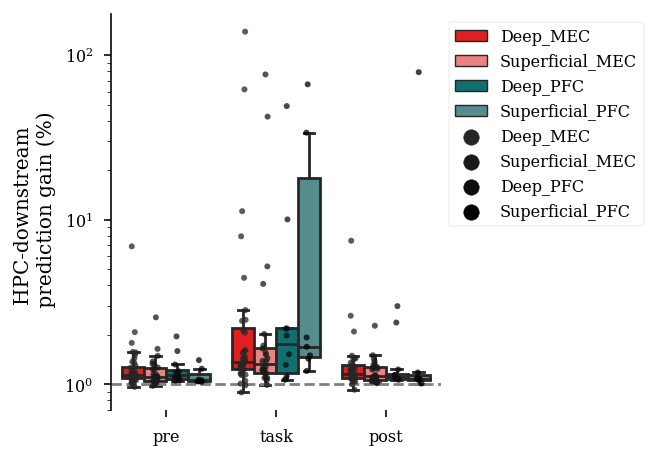

In [58]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)

group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))


ax = sns.boxplot(
    y="prediction_gain_median",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="prediction_gain_median",
    x="epoch_i",
    hue="ca1_sub_layer_targ_reg",
    data=results,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)

# # move legend to the right
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("HPC-downstream \n prediction gain (%)")
plt.axhline(1, color="grey", linestyle="--")
plt.yscale("log")
plt.xlabel("")
# plt.savefig(
#     os.path.join(fig_save_path, "deep_sup_ratio_predict.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


In [126]:
df_wide = pd.pivot(
    results,
    index=["basepath", "epoch_i"],
    columns="ca1_sub_layer_targ_reg",
    values=["prediction_gain_median", "testing_error"],
).reset_index()
df_wide
# df_wide.basepath.value_counts()

basepath epoch_i  \
ca1_sub_layer_targ_reg                                                
0                                 Z:\Data\AYAold\AYA7\day19    post   
1                                 Z:\Data\AYAold\AYA7\day19     pre   
2                                 Z:\Data\AYAold\AYA7\day19    task   
3                                 Z:\Data\AYAold\AYA7\day20    post   
4                                 Z:\Data\AYAold\AYA7\day20     pre   
..                                                      ...     ...   
145                     Z:\Data\Kenji\i01_maze01_MS.001_003    task   
146                             Z:\Data\ORproject\OR18\day1    post   
147                             Z:\Data\ORproject\OR18\day1     pre   
148                             Z:\Data\ORproject\OR18\day2    post   
149                             Z:\Data\ORproject\OR18\day2     pre   

                       prediction_gain_median                            \
ca1_sub_layer_targ_reg               Deep_MEC  Deep_PFC Superficial_MEC   
0                                    1.256840       NaN             NaN   
1                                    1.264303       NaN             NaN   
2                                    1.308712       NaN             NaN   
3                                    1.094853       NaN             NaN   
4                                    1.113749       NaN             NaN   
..                                        ...       ...             ...   
145                                       NaN       NaN        4.083591   
146                                       NaN  1.068359             NaN   
147                                       NaN  1.201722             NaN   
148                                       NaN  2.378665             NaN   
149                                       NaN  1.186998             NaN   

                                       testing_error                           \
ca1_sub_layer_targ_reg Superficial_PFC      Deep_MEC Deep_PFC Superficial_MEC   
0                                  NaN       0.27666      NaN             NaN   
1                                  NaN       0.96129      NaN             NaN   
2                                  NaN       1.36643      NaN             NaN   
3                                  NaN       4.08478      NaN             NaN   
4                                  NaN       4.07003      NaN             NaN   
..                                 ...           ...      ...             ...   
145                                NaN           NaN      NaN         8.40857   
146                                NaN           NaN  2.96654             NaN   
147                                NaN           NaN  2.61545             NaN   
148                                NaN           NaN  8.64921             NaN   
149                                NaN           NaN  6.16813             NaN   

                                        
ca1_sub_layer_targ_reg Superficial_PFC  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  
..                                 ...  
145                                NaN  
146                                NaN  
147                                NaN  
148                                NaN  
149                                NaN  

[150 rows x 10 columns]

In [127]:
def ab_ratio(a, b):
    return (a - b) / (a + b)


df_wide["deep_sup_mec_pred_gain_ratio"] = ab_ratio(
    df_wide["prediction_gain_median"]["Deep_MEC"] + 1,
    df_wide["prediction_gain_median"]["Superficial_MEC"] + 1,
)
df_wide["deep_sup_pfc_pred_gain_ratio"] = ab_ratio(
    df_wide["prediction_gain_median"]["Deep_PFC"] + 1,
    df_wide["prediction_gain_median"]["Superficial_PFC"] + 1,
)
df_wide["deep_sup_mec_test_error_ratio"] = ab_ratio(
    df_wide["testing_error"]["Deep_MEC"] + 1,
    df_wide["testing_error"]["Superficial_MEC"] + 1,
)
df_wide["deep_sup_pfc_test_error_ratio"] = ab_ratio(
    df_wide["testing_error"]["Deep_PFC"] + 1,
    df_wide["testing_error"]["Superficial_PFC"] + 1,
)


In [131]:
df_long = pd.DataFrame()
df_long["deep_sup_mec_pfc_test_error_ratio"] = np.hstack(
    [df_wide.deep_sup_mec_test_error_ratio, df_wide.deep_sup_pfc_test_error_ratio]
)
df_long["deep_sup_mec_pfc_pred_gain_ratio"] = np.hstack(
    [df_wide.deep_sup_mec_pred_gain_ratio, df_wide.deep_sup_pfc_pred_gain_ratio]
)
df_long["epoch_i"] = np.hstack([df_wide.epoch_i, df_wide.epoch_i])
df_long["basepath"] = np.hstack([df_wide.basepath, df_wide.basepath])
df_long["downstream_region"] = np.hstack(
    [["mec"] * len(df_wide.basepath), ["pfc"] * len(df_wide.basepath)]
)

df_long


,deep_sup_mec_pfc_test_error_ratio,deep_sup_mec_pfc_pred_gain_ratio,epoch_i,basepath,downstream_region
0,NaN,NaN,post,Z:\Data\AYAold\AYA7\day19,mec
1,NaN,NaN,pre,Z:\Data\AYAold\AYA7\day19,mec
2,NaN,NaN,task,Z:\Data\AYAold\AYA7\day19,mec
3,NaN,NaN,post,Z:\Data\AYAold\AYA7\day20,mec
4,NaN,NaN,pre,Z:\Data\AYAold\AYA7\day20,mec
...,...,...,...,...,...
295,NaN,NaN,task,Z:\Data\Kenji\i01_maze01_MS.001_003,pfc
296,NaN,NaN,post,Z:\Data\ORproject\OR18\day1,pfc
297,NaN,NaN,pre,Z:\Data\ORproject\OR18\day1,pfc
298,NaN,NaN,post,Z:\Data\ORproject\OR18\day2,pfc


In [104]:
# df_wide_2 = pd.pivot(
#     df_long,
#     index=["basepath","downstream_region"],
#     columns="epoch_i",
#     values=["deep_sup_mec_test_error_ratio", "deep_sup_mec_pred_gain_ratio"],
# ).reset_index()
# df_wide_2

In [ ]:
df_long[(df_long.epoch_i == "pre") & (df_long.downstream_region == "pfc")]

In [132]:
print(df_long[(df_long.epoch_i == "pre") & ~np.isnan(df_long.deep_sup_mec_pfc_test_error_ratio) & (df_long.downstream_region == "pfc")].basepath.value_counts())
# print(df_long[(df_long.epoch_i == "pre") & ~np.isnan(df_long.deep_sup_mec_test_error_ratio)].basepath.value_counts())

Z:\Data\FujisawaS\EE\EE0622fm    1
Z:\Data\FujisawaS\EE\EE0627fm    1
Z:\Data\HMC1\day10               1
Z:\Data\HMC1\day12               1
Z:\Data\HMC1\day13               1
Z:\Data\HMC1\day8                1
Z:\Data\HMC1\day9                1
Name: basepath, dtype: int64


Text(0.5, 1.0, 'below zero is bias for superficial')

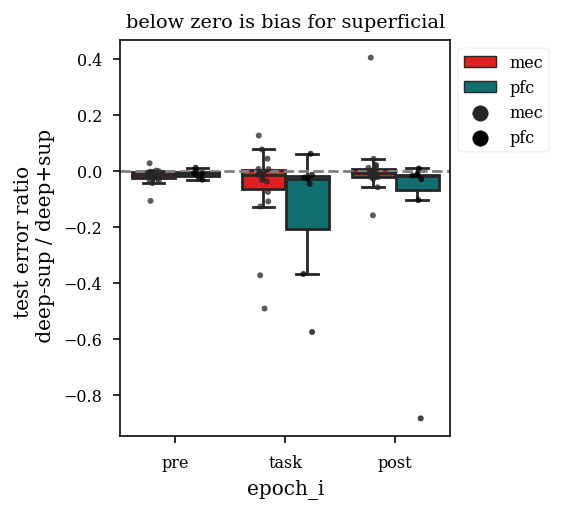

In [105]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)
group_colors = {"mec": "#de2020", "pfc": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = sns.boxplot(
    y="deep_sup_mec_test_error_ratio",
    x="epoch_i",
    order=["pre", "task", "post"],
    hue="downstream_region",
    hue_order=group_colors.keys(),
    data=df_long,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="deep_sup_mec_test_error_ratio",
    x="epoch_i",
    order=["pre", "task", "post"],
    hue="downstream_region",
    data=df_long,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)
plt.ylabel("test error ratio \n deep-sup / deep+sup")
plt.axhline(0, color="grey", linestyle="--")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("below zero is bias for superficial")

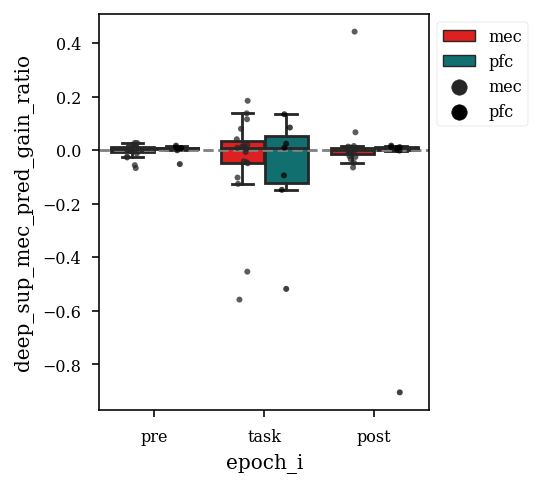

In [62]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)

group_colors = {"mec": "#de2020", "pfc": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))


ax = sns.boxplot(
    y="deep_sup_mec_pred_gain_ratio",
    x="epoch_i",
    order=["pre", "task", "post"],
    hue="downstream_region",
    hue_order=group_colors.keys(),
    data=df_long,
    showfliers=False,
    saturation=1,
)
sns.stripplot(
    y="deep_sup_mec_pred_gain_ratio",
    x="epoch_i",
    order=["pre", "task", "post"],
    hue="downstream_region",
    data=df_long,
    dodge=True,
    color="k",
    size=3,
    alpha=0.75,
)
plt.axhline(0, color="grey", linestyle="--")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))


## testing below

In [3]:
basepath = r"Z:\Data\HMC1\day8"
# basepath = r"Z:\Data\AYAold\AYA9\day14"

st, cell_metrics = loading.load_spikes(basepath, brainRegion=["CA1", "PFC", "MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])


In [4]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]


In [50]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="firing_rate",
)


In [7]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)


In [53]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LinearRegression, RidgeCV

X = st_par[cell_metrics.brainRegion.str.contains("MEC").values, :]
# # get pca dims that explain XX of the variance
X = PCA(n_components=0.80, svd_solver="full").fit_transform(X.T)

y = st_par[ca1_deep_idx, :][4, :]
# bad_idx = np.hstack(np.isinf(y) | np.isnan(y))
# y = y[~bad_idx]
# X = X[~bad_idx, :]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

clf = RidgeCV().fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.042625781370491334
0.008360100345581545


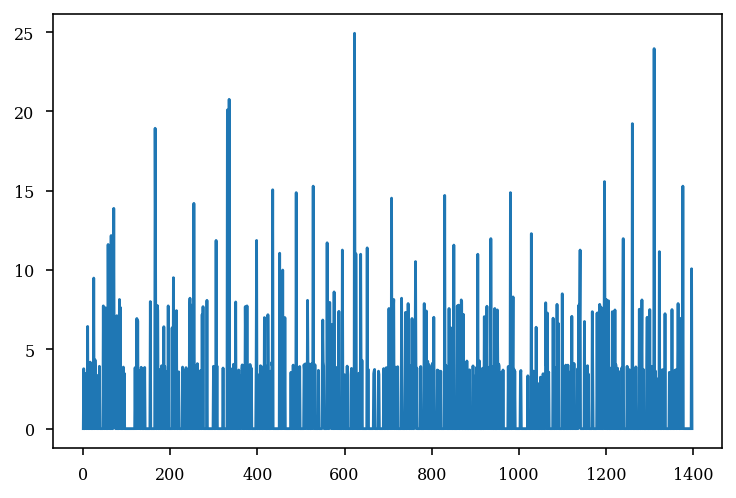

In [44]:
plt.plot(y_train)


(0.0, 50.0)

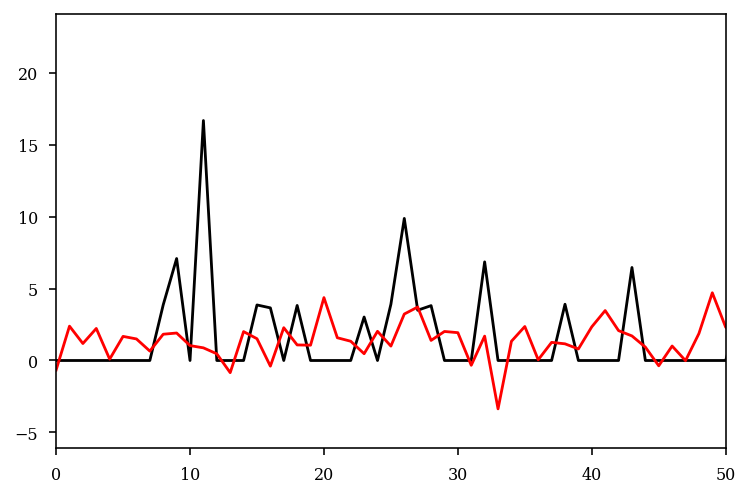

In [45]:
plt.plot(y_test, color="k")

plt.plot(clf.predict(X_test), color="red")
plt.xlim(0, 50)


In [55]:
from pyglmnet import GLM

glm_poisson = GLM(
    distr="poisson",
    alpha=0.05,
    learning_rate=1.0,
    score_metric="pseudo_R2",
    reg_lambda=1e-7,
)
glm_poisson.fit(X_train, y_train)

# predict spike counts
# ypred_lg = glm_poisson.predict(X_test)


<
Distribution | poisson
alpha | 0.05
max_iter | 1000.00
lambda: 0.00
>

(0.0, 50.0)

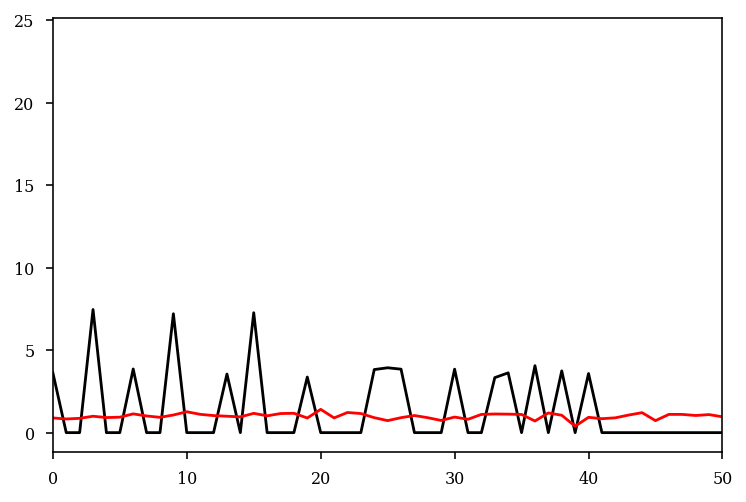

In [56]:
plt.plot(y_test, color="k")

plt.plot(glm_poisson.predict(X_test), color="red")
plt.xlim(0, 50)


<AxesSubplot:>

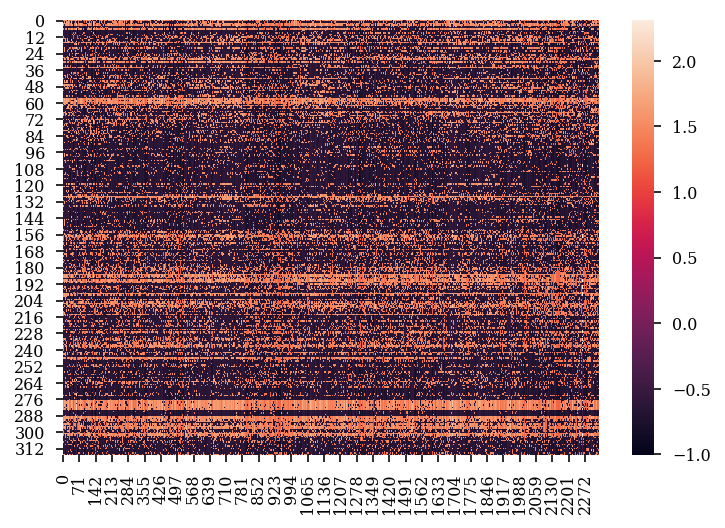

In [45]:
sns.heatmap(X)


In [ ]:
cell_metrics.putativeCellType.value_counts()


In [46]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

# bst = st[ripple_epochs].bin(ds=0.02)

# X = bst.data.copy()
X = st_par.copy()
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(X)


ca1_deep_idx = cell_metrics.brainRegion.str.contains("CA1").values & (
    cell_metrics.deepSuperficial == "Deep"
)
ca1_sup_idx = cell_metrics.brainRegion.str.contains("CA1").values & (
    cell_metrics.deepSuperficial == "Superficial"
)

# X_ca1 = PCA().fit_transform(X[ca1_idx ,:].T)

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_deep_idx, :].T,
    X[cell_metrics.brainRegion.str.contains("PFC").values, :].T,
    test_size=0.4,
    random_state=42,
)


In [47]:
from ripple_heterogeneity.utils import (
    reduced_rank_regressor,
    system_identifier,
    multivariate_regressor,
)
from scipy import around
from scipy import size
from scipy.linalg import norm


def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, "fro"), 2) / size(matrix2, 0), 5)


RANK = 10
REG = 1e-6  # regularization on the model

reg = reduced_rank_regressor.ReducedRankRegressor(X_train, y_train, RANK, REG)
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
print(training_error, testing_error)

reg = multivariate_regressor.MultivariateRegressor(
    X_train,
    y_train,
    REG,
)
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
print(training_error, testing_error)


sys_id = system_identifier.SystemIdentifier(X_train, y_train, RANK, REG)
training_error = sqerr(sys_id.predict(X_train), y_train)
testing_error = sqerr(sys_id.predict(X_test), y_test)
print(training_error, testing_error)


22.67356 23.03099
22.32495 23.34175
22.24444 23.49057


(0.0, 100.0)

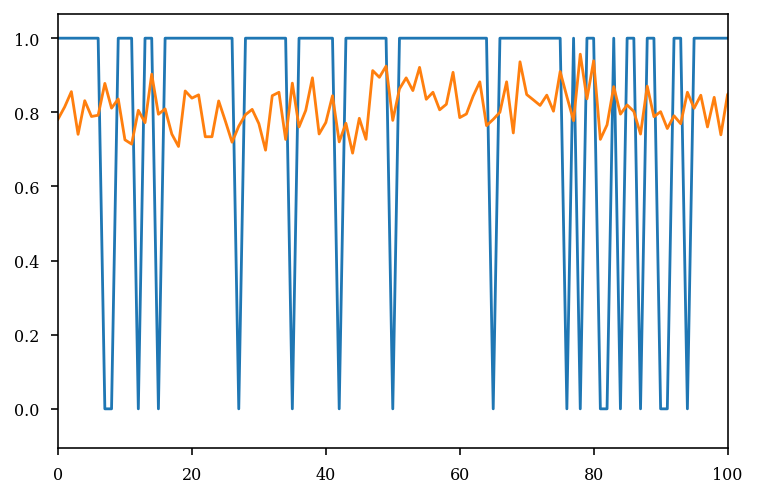

In [49]:
plt.plot(y_train[:, 0])
plt.plot(reg.predict(X_train)[:, 0])

plt.xlim(0, 100)


In [113]:
sys_id = system_identifier.SystemIdentifier(X_train, y_train, RANK, REG)
training_error = sqerr(sys_id.predict(X_train), y_train)
testing_error = sqerr(sys_id.predict(X_test), y_test)
training_error, testing_error


(37.3465, 42.8783)

In [106]:
training_error = sqerr(reg.predict(X_train), y_train)
testing_error = sqerr(reg.predict(X_test), y_test)
training_error, testing_error


(40.18082, 42.92914)

<AxesSubplot:>

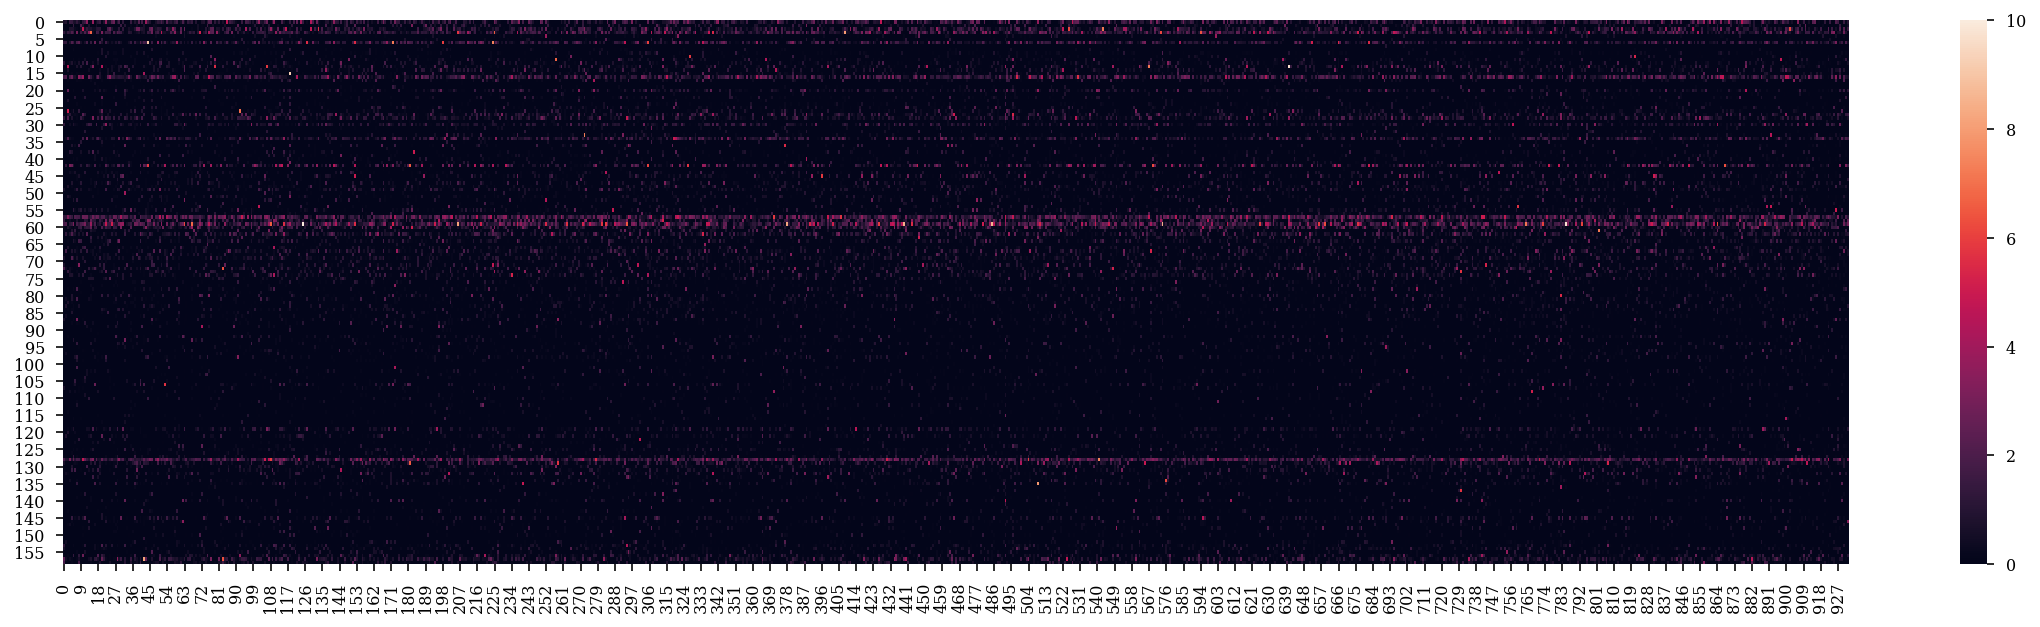

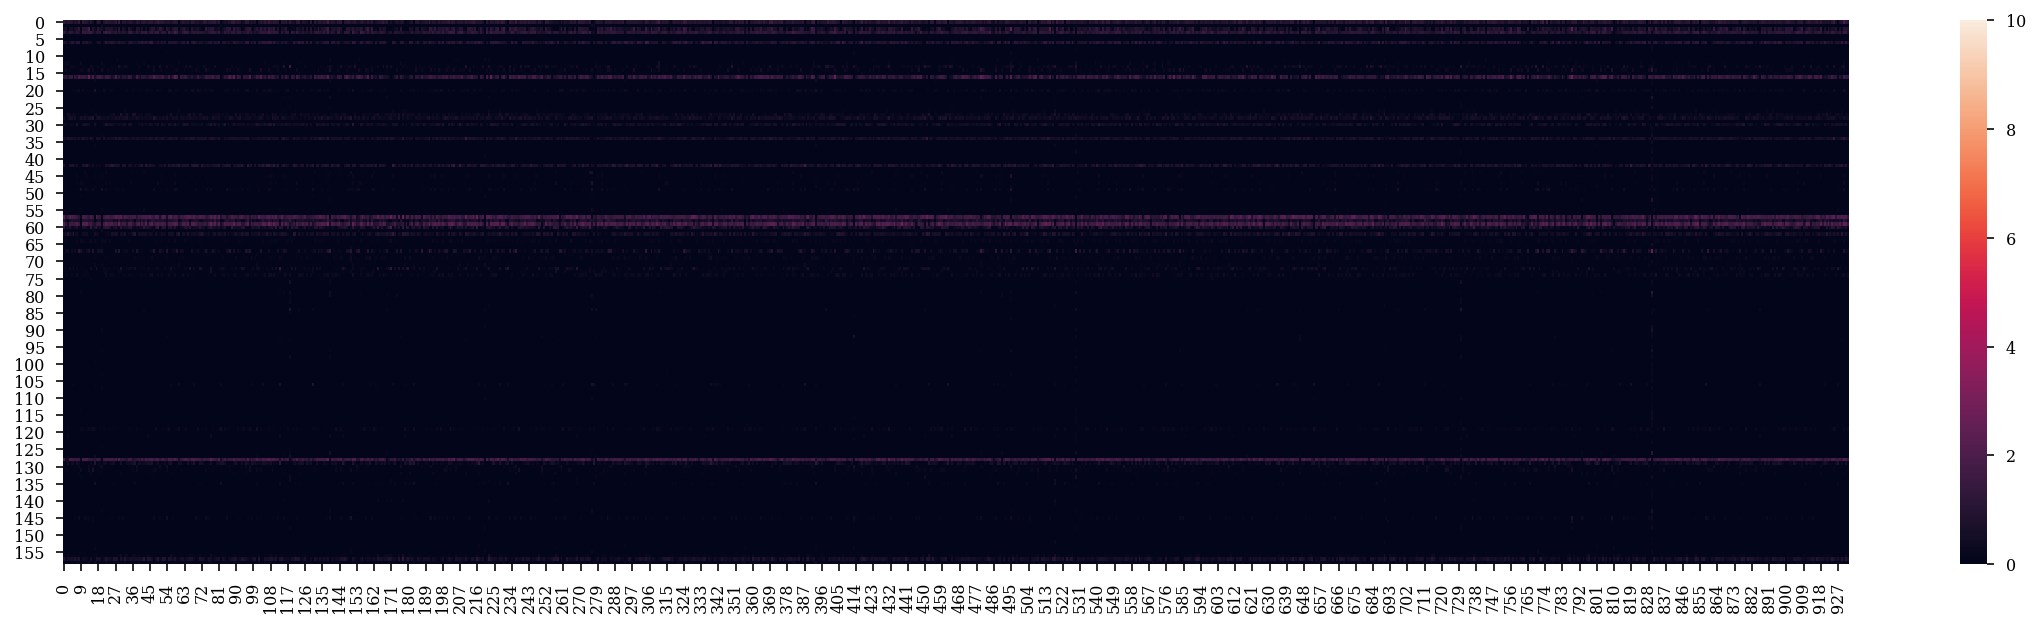

In [126]:
plt.figure(figsize=(20, 5))
sns.heatmap(y_test.T, vmin=0, vmax=10)
plt.figure(figsize=(20, 5))
sns.heatmap(reg.predict(X_test).T, vmin=0, vmax=10)


In [96]:
"""Machine learning with linear models - a demo
Requires scipy to be installed.
Implemented by Chris Rayner (2015)
dchrisrayner AT gmail DOT com
My Ph.D. supervisor Dr. Michael Bowling introduced me to RRR; Dr. Tijl De Bie
gave a great talk on subspace system identification in 2005 that I modeled my
implementation on: http://videolectures.net/slsfs05_bie_slasi/
"""

# import multivariate_regressor
# import reduced_rank_regressor
# import system_identifier

from scipy import around
from scipy import size
from scipy.linalg import norm
from numpy.random import seed

DIM_X = 20  # dimensionality of input
DIM_Y = 15  # dimensionality of output
RANK = 10  # internal rank/bottleneck
NOISE_SCALE = 1.0
NUM_SAMPLES = 5000
SPLIT = int(NUM_SAMPLES / 2)  # train/test split
REG = 1e-6  # regularization on the model


def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, "fro"), 2) / size(matrix2, 0), 5)


if __name__ == "__main__":
    seed(10)
    for model in [multivariate_regressor, reduced_rank_regressor, system_identifier]:
        # generate the data:
        print(model.ideal_data.__doc__)
        XX, YY = model.ideal_data(NUM_SAMPLES, DIM_X, DIM_Y, RANK, NOISE_SCALE)
        # run each of the regressors against it:
        for regressor in [
            multivariate_regressor.MultivariateRegressor(XX[:SPLIT], YY[:SPLIT], REG),
            reduced_rank_regressor.ReducedRankRegressor(
                XX[:SPLIT], YY[:SPLIT], RANK, REG
            ),
            system_identifier.SystemIdentifier(XX[:SPLIT], YY[:SPLIT], RANK, REG),
        ]:
            print("  {}".format(regressor))
            training_error = sqerr(regressor.predict(XX[:SPLIT]), YY[:SPLIT])
            testing_error = sqerr(regressor.predict(XX[SPLIT:]), YY[SPLIT:])
            print(
                "    Training error: {}\n    Testing error: {}".format(
                    training_error, testing_error
                )
            )


Full rank data
  Multivariate Linear Regression
    Training error: 14.73986
    Testing error: 15.24806
  Reduced Rank Regressor (rank = 10)
    Training error: 29.60288
    Testing error: 30.80116
  Linear Dynamical System
    Training error: 14.72381
    Testing error: 15.36072
Low rank data
  Multivariate Linear Regression
    Training error: 14.78114
    Testing error: 14.86847
  Reduced Rank Regressor (rank = 10)
    Training error: 14.80385
    Testing error: 14.84956
  Linear Dynamical System
    Training error: 17.17712
    Testing error: 16.02869
Linear system data
  Multivariate Linear Regression
    Training error: 113.73439
    Testing error: 115.23946
  Reduced Rank Regressor (rank = 10)
    Training error: 131.07372
    Testing error: 133.97695
  Linear Dynamical System
    Training error: 23.75118
    Testing error: 23.32171


In [94]:
XX, YY = reduced_rank_regressor.ideal_data(NUM_SAMPLES, DIM_X, DIM_Y, RANK, NOISE_SCALE)
XX.shape, YY.shape


((5000, 20), (5000, 15))